# Train DSF e iESPnet

In [1]:
import sys
import os
import torch

import torchaudio.transforms    as T
import torch.optim              as optim
import pandas                   as pd
import numpy                    as np

from torchvision       import transforms
from torch.utils.data  import DataLoader
from torch             import nn
from sklearn.metrics   import balanced_accuracy_score, recall_score, precision_score, mean_absolute_error, average_precision_score


sys.path.append(os.path.abspath(os.path.join('..','..','iESPnet_SRC_main','utilities')))
from Generator         import SeizureDatasetLabelTimev2, scale_spec, permute_spec, smoothing_label
from Model             import iESPnet
from TrainEval         import train_model_opt, test_model, train_model, get_thr_output, get_performance_indices
from IO                import get_spectrogram_2

sys.path.append(os.path.abspath(os.path.join('..','05-Train-Test')))
from utilit_train_test import make_weights_for_balanced_classes

sys.path.append(os.path.abspath(os.path.join('../../..','03 Dynamic-Spatial-Filtering')))
from models                         import DynamicSpatialFilter

In [2]:
torch.manual_seed(0)

In [3]:
# direccion donde se encuentran los espectrogramas 

SPE_DIR        = '/media/martin/Disco2/Rns_Data/PITT_PI_EEG_PROCESS/'
meta_data_file = '/media/martin/Disco2/Rns_Data/PITT_PI_EEG_PROCESS/METADATA/allfiles_metadata.csv'

df_meta        = pd.read_csv(meta_data_file)

In [4]:
# Variables iESPnet

FREQ_MASK_PARAM = 10
TIME_MASK_PARAN = 20
N_CLASSES       = 1
learning_rate   = 1e-3
batch_size      = 64 #128
epochs          = 20
num_workers     = 4


save_path       = 'models_DSF_iESPnet/'
patients        = df_meta['rns_id'].unique().tolist()

In [5]:
# Variables DSF

denoising          = 'autoreject'   # 'autoreject' 'data_augm' 
model              = 'stager_net'
dsf_type           = 'dsfd'         # 'dsfd' 'dsfm_st'
mlp_input          = 'log_diag_cov'
dsf_soft_thresh    = False
dsf_n_out_channels = None
n_channels         = 4

In [6]:
# hiperparametros iESPnet

hparams = {
           "n_cnn_layers" : 3,
           "n_rnn_layers" : 3,
           "rnn_dim"      : [150, 100, 50],
           "n_class"      : N_CLASSES,
           "out_ch"       : [8,8,16],
           "dropout"      : 0.3,
           "learning_rate": learning_rate,
           "batch_size"   : batch_size,
           "num_workers"  : num_workers,
           "epochs"       : epochs
          }

In [7]:
# ejemplo para un unico paciente s = 0 --- patient = PIT-RNS1603

s = 28

In [8]:
model1 = DynamicSpatialFilter(
                              n_channels, 
                              mlp_input            = mlp_input, 
                              n_out_channels       = dsf_n_out_channels, 
                              apply_soft_thresh    = dsf_soft_thresh
                             )

model2 = iESPnet(
                 hparams['n_cnn_layers'],
                 hparams['n_rnn_layers'],
                 hparams['rnn_dim'],
                 hparams['n_class'],
                 hparams['out_ch'],
                 hparams['dropout'],
                )

In [9]:
save_runs        = save_path + patients[s] + '/runs/'
save_models      = save_path + patients[s] + '/models/'
save_predictions = save_path + patients[s] + '/results/'
save_figs        = save_path + patients[s] + '/figs/'

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if not os.path.exists(save_runs):
    os.makedirs(save_runs)
    
if not os.path.exists(save_models):
    os.makedirs(save_models)
    
if not os.path.exists(save_predictions):
    os.makedirs(save_predictions)
    
if not os.path.exists(save_figs):
    os.makedirs(save_figs)

print('Running training for subject ' + patients[s] + ' [s]: ' + str(s))

Running training for subject PIT-RNS0427 [s]: 28


In [10]:
# define train y test de df_meta

train_df = df_meta.copy()
test_df  = df_meta[df_meta['rns_id'] == patients[s]]
test_df.reset_index(drop=True, inplace=True)
train_df.drop(train_df[train_df['rns_id'] == patients[s]].index, inplace = True)

In [11]:
# Dataloaders creados

train_data = SeizureDatasetLabelTimev2(      
                                       file             = train_df,
                                       root_dir         = SPE_DIR,
                                       transform        = None, 
                                       target_transform = smoothing_label(),
                                      )

In [12]:
transform_train = transforms.Compose([
                                      T.FrequencyMasking(FREQ_MASK_PARAM),
                                      T.TimeMasking(TIME_MASK_PARAN), 
                                      permute_spec()                                                                     
                                    ])

In [13]:
# testing data should be balanced, just be "as it is"

test_data = SeizureDatasetLabelTimev2(
                                      file             = test_df,
                                      root_dir         = SPE_DIR,
                                      transform        = None,
                                      target_transform = smoothing_label()  
                                     )

In [14]:
# se debe balancear train_df
weights = make_weights_for_balanced_classes(train_df, [0,1], n_concat=1)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [15]:
outputfile = save_models + 'model'

### Funcion train_model_opt

In [16]:
avg_train_losses = []
avg_train_accs   = []

In [17]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print('Using {} device'.format(device))

Using cuda device


In [18]:
# following pytorch suggestion to speed up training

torch.backends.cudnn.benchmark = True

In [19]:
# variables o atributos de la funcion train_model_opt

# model1, model2, hparams, epochs, train_data, transform_train, sampler, save_path

# model1: DSF
# model2: iESPnet
# hparams: 
# epochs:
# train_data: dataloader de iEEG con smoothing label
# transforn_train: transformación (augmentation) de espectrogramas 
# sampler:
# save_path:

# El dataloader es un iterador y se debe interpretar como tal, para acceder se debe utilizar o enumerate o next 


In [20]:
kwargs = {'num_workers': hparams["num_workers"], 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader(train_data, batch_size = hparams["batch_size"], sampler = sampler, **kwargs)

In [21]:
# move model1 to device

model1.to(device)

DynamicSpatialFilter(
  (feat_extractor): SpatialFeatureExtractor()
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=20, bias=True)
  )
)

In [22]:
# move model1 to device

model2.to(device)

iESPnet(
  (freqcnn): Sequential(
    (0): Conv2d(4, 8, kernel_size=(120, 1), stride=(1, 1), padding=(119, 0), dilation=(2, 1), bias=False)
    (1): ReLU()
    (2): InstanceNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  )
  (timecnn): Sequential(
    (0): Conv2d(4, 8, kernel_size=(1, 181), stride=(1, 1), padding=(0, 180), dilation=(1, 2), bias=False)
    (1): ReLU()
    (2): InstanceNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  )
  (cnn_ori): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
  (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
  (rescnn_layers): Sequential(
    (0): ResidualCNNbatch(
      (cnn1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (cnn2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout1): Dropout(p=0.3, inplace=False)
      (dropout2): Dropout(p=0.3, inpla

In [23]:
print('Num Model Parameters', sum([param1.nelement() for param1 in model1.parameters()]))

Num Model Parameters 120


In [24]:
print('Num Model Parameters', sum([param2.nelement() for param2 in model2.parameters()]))

Num Model Parameters 1654837


In [25]:
optimizer1 = optim.AdamW(model1.parameters(), hparams['learning_rate'], weight_decay=1e-4)

optimizer2 = optim.AdamW(model2.parameters(), hparams['learning_rate'], weight_decay=1e-4)

In [26]:
scheduler1 = optim.lr_scheduler.OneCycleLR(
                                            optimizer1, 
                                            max_lr          = hparams['learning_rate'], 
                                            steps_per_epoch = int(len(train_loader)),
                                            epochs          = hparams['epochs'],
                                            anneal_strategy = 'linear'
                                            )

In [27]:
scheduler2 = optim.lr_scheduler.OneCycleLR(
                                            optimizer2, 
                                            max_lr          = hparams['learning_rate'], 
                                            steps_per_epoch = int(len(train_loader)),
                                            epochs          = hparams['epochs'],
                                            anneal_strategy = 'linear'
                                            )

In [28]:
criterion = nn.BCEWithLogitsLoss().to(device)

In [29]:
'''

for epoch in range(1, epochs + 1):
    # agregar todos los argumentos necesarios
    train_losses, train_aucpr = training_DSF_iESPnet(model, device, train_loader, transform_train, criterion, optimizer, scheduler, epoch)
    
    train_loss = np.average(train_losses)

    avg_train_losses.append(train_loss)
    
    avg_train_accs.append(train_aucpr)
    
'''

'\n\nfor epoch in range(1, epochs + 1):\n    # agregar todos los argumentos necesarios\n    train_losses, train_aucpr = training_DSF_iESPnet(model, device, train_loader, transform_train, criterion, optimizer, scheduler, epoch)\n    \n    train_loss = np.average(train_losses)\n\n    avg_train_losses.append(train_loss)\n    \n    avg_train_accs.append(train_aucpr)\n    \n'

##### Función training_DSF_iESPnet

In [30]:
# variables o atributos de la funcion training_DSF_iESPnet

# model1, model2, device, train_loader, transform_train, criterion, optimizer, scheduler, epoch

In [31]:
train_loss      = 0.0
train_losses    = []
cont            = 0

In [32]:
model1.train()

DynamicSpatialFilter(
  (feat_extractor): SpatialFeatureExtractor()
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=20, bias=True)
  )
)

In [33]:
model2.train()

iESPnet(
  (freqcnn): Sequential(
    (0): Conv2d(4, 8, kernel_size=(120, 1), stride=(1, 1), padding=(119, 0), dilation=(2, 1), bias=False)
    (1): ReLU()
    (2): InstanceNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  )
  (timecnn): Sequential(
    (0): Conv2d(4, 8, kernel_size=(1, 181), stride=(1, 1), padding=(0, 180), dilation=(1, 2), bias=False)
    (1): ReLU()
    (2): InstanceNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  )
  (cnn_ori): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
  (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
  (rescnn_layers): Sequential(
    (0): ResidualCNNbatch(
      (cnn1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (cnn2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout1): Dropout(p=0.3, inplace=False)
      (dropout2): Dropout(p=0.3, inpla

In [34]:
for batch_idx, _data in enumerate(train_loader):

    cont+=1
    eeg, labels = _data
    break

In [35]:
eeg.shape

torch.Size([64, 4, 22500])

In [36]:
labels.shape

torch.Size([64, 181])

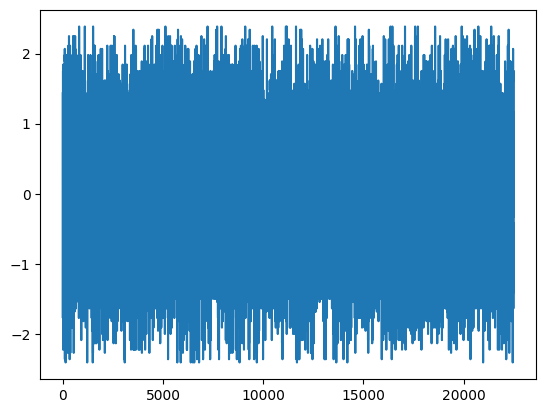

In [37]:
import matplotlib.pyplot as plt

plt.plot(eeg[0,0,:])

In [38]:
eeg, labels = eeg.to(device), labels.to(device)

In [39]:
optimizer1.zero_grad(set_to_none=True)
optimizer2.zero_grad(set_to_none=True)

In [40]:
outputs1 = model1(eeg)
outputs1 = outputs1.squeeze(1)

In [41]:
# reshape para tener el mismo tamaño que necesita el espectrograma

print(outputs1.shape)

torch.Size([64, 4, 22500])


In [42]:
# Suponiendo que eeg_data es tu tensor de tamaño [64, 4, 22500]

mean = outputs1.mean(dim=2, keepdim=True)  # Media a lo largo de la dimensión 2 (22500 datos)
std  = outputs1.std(dim=2, keepdim=True)    # Desviación estándar a lo largo de la dimensión 2 (22500 datos)

In [43]:
# usando media por canal

outputs2 = (outputs1 - mean) / std

In [44]:
# usando media global

outputs3 = (outputs1 - outputs1.mean()) / outputs1.std()

In [45]:
outputs1 = outputs1.to('cpu')
outputs2 = outputs2.to('cpu')
outputs3 = outputs3.to('cpu')

In [54]:
# variables y atributos para crear el espectrograma

# signal, fs, n_fft = 256, win_len = None, hop_len = None, power = 2.0

ECOG_SAMPLE_RATE = 250
ECOG_CHANNELS    = 4
TT               = 1000 # window length
SPEC_WIN_LEN     = int(ECOG_SAMPLE_RATE * TT / 1000 ) # win size
overlap          = 500 
SPEC_HOP_LEN     = int(ECOG_SAMPLE_RATE * (TT - overlap) / 1000) # Length of hop between windows.
SPEC_NFFT        = 500  # to see changes in 0.5 reso
top_db           = 40.0

In [55]:
from scipy import fft as sp_fft
import librosa

def get_spectrogram_v2(signal, fs, n_fft = 256, win_len = None, hop_len = None, top_db = 40.0, power = 2.0):

    wind_dic={'periodic': True, 'beta': 10}

    spectrogram = T.Spectrogram(
                                n_fft=n_fft, 
                                win_length=win_len,
                                hop_length=hop_len, 
                                pad=0,
                                window_fn =torch.kaiser_window,
                                normalized=False,
                                power=power, 
                                wkwargs=wind_dic
                               )
    
    time   = np.arange(win_len/2, signal.shape[-1] + win_len/2 + 1, win_len - (win_len-hop_len))/float(fs)
    time  -= (win_len/2) / float(fs)

    freqs  = sp_fft.rfftfreq(n_fft, 1/fs)

    spec   = spectrogram(signal)
    spec   = spec.detach().cpu().numpy()

    spec   = librosa.power_to_db(spec, top_db = top_db)

    # save up to 60 Hz
    idx_60 = np.where(freqs <= 60)[0][-1]

    spec   = spec[:, :, :idx_60, :]

    return spec #, time, freqs  ver de agregar para plot 

In [56]:
spectrograms1 = get_spectrogram_v2(outputs1, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN, top_db)

In [57]:
spectrograms2 = get_spectrogram_v2(outputs2, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN, top_db)

In [58]:
spectrograms3 = get_spectrogram_v2(outputs3, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN, top_db)

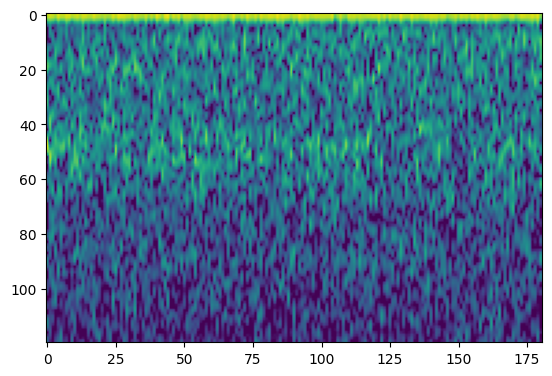

In [59]:
plt.imshow(spectrograms1[0,0,:,:])
plt.show()

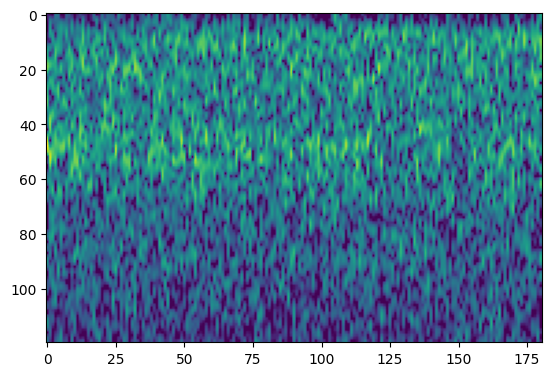

In [60]:
plt.imshow(spectrograms2[0,0,:,:])

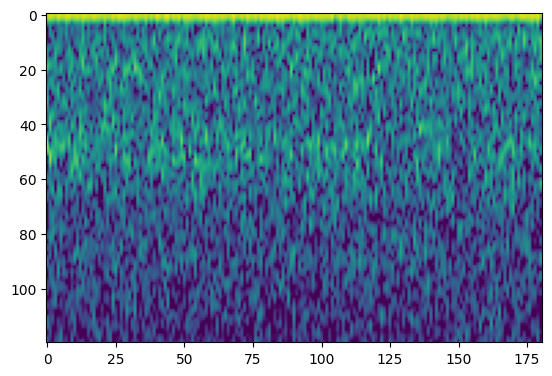

In [61]:
plt.imshow(spectrograms3[0,0,:,:])

In [ ]:
print(spectrograms.shape)

(64, 4, 120, 181)


In [ ]:
spectrograms = torch.from_numpy(spectrograms)
print(spectrograms.shape)

torch.Size([64, 4, 120, 181])


In [ ]:
# visualización de espectrogramas

In [ ]:
spectrograms_transformed =  transform_train(spectrograms)

In [ ]:
print(spectrograms_transformed.shape)

torch.Size([64, 4, 120, 181])


In [ ]:
spectrograms2train = torch.cat((spectrograms, spectrograms_transformed), axis=0) #fijate acá el axis
print(spectrograms2train.shape)

torch.Size([128, 4, 120, 181])


In [ ]:
spectrograms2train = spectrograms2train.to(device)

In [ ]:
labels2train = torch.cat((labels, labels), axis=0) 

In [ ]:
output2 = model2(spectrograms2train)

In [ ]:
m = nn.Sigmoid()
probs = m(output2)

y_true  = torch.max(labels2train, dim =1)[0]
y_pred  = torch.max(probs, dim=1)[0]

In [ ]:
if cont==1:
    Y_true = y_true
    Y_pred = y_pred

else:                
    Y_true = torch.cat((Y_true, y_true), axis=0)
    Y_pred = torch.cat((Y_pred, y_pred), axis=0)

In [ ]:
# Compute loss

loss = criterion(output2, labels2train)

# Perform backward pass

loss.backward()
train_loss += loss.item()

# Perform optimization

optimizer1.step()
optimizer2.step()
scheduler1.step()
scheduler2.step()

In [ ]:
# record training loss
train_losses.append(loss.item())

del _data
torch.cuda.empty_cache()

In [ ]:
y_val_true, val_pred = Y_true.to('cpu').detach().numpy(), Y_pred.to('cpu').detach().numpy()

if np.isnan(val_pred).any():
    print('nan found in pred')
    train_aucpr = 0
else:   
    train_aucpr= average_precision_score(y_val_true,val_pred)
    
print('Train Epoch: {} \tTrainLoss: {:.6f} \tTrainAUCpr: {:.6f}'.format(1, np.mean(train_losses), train_aucpr))

Train Epoch: 1 	TrainLoss: 0.693019 	TrainAUCpr: 0.550788


In [ ]:
train_loss = np.average(train_losses)

avg_train_losses.append(train_loss)

avg_train_accs.append(train_aucpr)

print('saving the model')

torch.save({
    'epoch': 1,
    'model_state_dict1': model1.state_dict(),
    'model_state_dict2': model2.state_dict(),
    'optimizer_state_dict1': optimizer1.state_dict(),
    'optimizer_state_dict2': optimizer2.state_dict(),
    }, outputfile + '_opt.pth')

saving the model


### Funcion test_model

# in testing
outputs_test  = test_model(model, hparams, best_path, test_data)


prediction_te = get_performance_indices(outputs_test['y_true'], outputs_test['y_prob'], best_thr)

In [ ]:
best_thr = 0.2
best_path = save_models + 'model_opt.pth'

In [ ]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print('Using {} device'.format(device))

Using cuda device


In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
kwargs = {'num_workers': hparams["num_workers"], 'pin_memory': True} if use_cuda else {}
    
# load model
checkpoint = torch.load(best_path)


In [ ]:
model1.load_state_dict(checkpoint['model_state_dict1'])

<All keys matched successfully>

In [ ]:
model2.load_state_dict(checkpoint['model_state_dict2'])

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test_data, batch_size=hparams['batch_size'], shuffle=False,**kwargs)

In [ ]:
def get_predictionv2(model1, model2, device, loader):
    
    model1.to(device)
    model2.to(device)

    model1.eval()
    model2.eval()
    with torch.no_grad():
        for i, data_ in enumerate(loader):
            eeg, labels = data_
            eeg, labels = eeg.to(device), labels.to(device)
            
            outputs1 = model1(eeg)
            outputs1 = outputs1.squeeze(1)
            outputs1 = outputs1.to('cpu')

            spectrograms = get_spectrogram_2(outputs1, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN, top_db)
            spectrograms = torch.from_numpy(spectrograms)
            spectrograms = spectrograms.to(device)

            outputs2 = model2(spectrograms)

            m     = nn.Sigmoid()
            probs = m(outputs2)

            # print(len(probs.shape))
            # avoiding shape issues when the last batch has only one element
            if len(probs.shape) == 1:
                probs.unsqueeze_(0)
                outputs2.unsqueeze_(0)
            if i==0:
                y_true = labels
                y_probs = probs
                y_outputs = outputs2

            else:                
                y_true    = torch.cat((y_true, labels), axis=0)
                y_probs   = torch.cat((y_probs, probs), axis=0)
                y_outputs = torch.cat((y_outputs, outputs2), axis=0)

y_true    = y_true.to('cpu').detach().numpy()
y_probs   = y_probs.to('cpu').detach().numpy()
y_outputs = y_outputs.to('cpu').detach().numpy()

l_true   = np.zeros((len(y_true,)))
idx_true = np.where(np.sum(y_true, axis=1)>0.0)[0].tolist()

l_true[idx_true] = 1    
t_true           = np.argmax(y_true[idx_true], axis=1)


prediction={
            'y_true': y_true,
            'y_prob': y_probs, 
            'y_output': y_outputs,
            't_true': t_true,
            'l_true': l_true
           }

In [ ]:
model1.to(device)
model2.to(device)

model1.eval()
model2.eval()
with torch.no_grad():
    for i, data_ in enumerate(test_loader):
        eeg, labels = data_
        break

In [ ]:
eeg, labels = eeg.to(device), labels.to(device)

In [ ]:
eeg.shape

torch.Size([64, 4, 22500])

In [ ]:
outputs1 = model1(eeg)
outputs1 = outputs1.squeeze(1)
outputs1 = outputs1.to('cpu')

---------------------------------------------
DynamicSpatialFilter input shape: torch.Size([64, 4, 22500])
After reshaping: torch.Size([64, 1, 4, 22500])
SpatialFeatureExtractor input shape: torch.Size([64, 1, 4, 22500])
SpatialFeatureExtractor output shape: torch.Size([64, 1, 4])
MLP output shape: torch.Size([64, 1, 20])
W shape: torch.Size([64, 1, 4, 4])
Bias shape: torch.Size([64, 1, 4, 1])
Output shape: torch.Size([64, 1, 4, 22500])


In [ ]:
spectrograms = get_spectrogram_2(outputs1, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN, top_db)
spectrograms = torch.from_numpy(spectrograms)
spectrograms = spectrograms.to(device)

In [ ]:
outputs2 = model2(spectrograms)

In [ ]:
m     = nn.Sigmoid()
probs = m(outputs2)

In [ ]:
probs

tensor([[0.5032, 0.4925, 0.4886,  ..., 0.4957, 0.4981, 0.5035],
        [0.4971, 0.4905, 0.4824,  ..., 0.4835, 0.4880, 0.5030],
        [0.4962, 0.4910, 0.4824,  ..., 0.4820, 0.4835, 0.5022],
        ...,
        [0.5117, 0.5075, 0.4985,  ..., 0.4992, 0.4938, 0.4947],
        [0.5144, 0.5135, 0.5045,  ..., 0.5038, 0.4944, 0.4980],
        [0.5205, 0.5164, 0.5154,  ..., 0.5128, 0.5051, 0.5184]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
if len(probs.shape) == 1:
    probs.unsqueeze_(0)
    outputs2.unsqueeze_(0)
if i==0:
    y_true = labels
    y_probs = probs
    y_outputs = outputs2
else:                
    y_true    = torch.cat((y_true, labels), axis=0)
    y_probs   = torch.cat((y_probs, probs), axis=0)
    y_outputs = torch.cat((y_outputs, outputs2), axis=0)

In [ ]:
y_true    = y_true.to('cpu').detach().numpy()
y_probs   = y_probs.to('cpu').detach().numpy()
y_outputs = y_outputs.to('cpu').detach().numpy()

l_true   = np.zeros((len(y_true,)))
idx_true = np.where(np.sum(y_true, axis=1)>0.0)[0].tolist()

l_true[idx_true] = 1    
t_true           = np.argmax(y_true[idx_true], axis=1)


prediction={
            'y_true': y_true,
            'y_prob': y_probs, 
            'y_output': y_outputs,
            't_true': t_true,
            'l_true': l_true
           }